# Übung 1 - Modellierung von PV-Stromerzeugung

Gruppe A

Autoren: David Kittel, Bernhard Mair, Karel Rusy, Lukas Windsteig

In [1]:
# Import von Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


__Vorgegebene Funktion zur Bestimmung des relativen Sonnenstands:__

In [2]:
def sonnenstand(laengengrad,breitengrad,time):
    """
    Diese Funktion erstellt einen Vektor für den Sonnenstand in 15 min
    Auflösung über ein Jahr

    die Variable "azimut" ergibt einen Vektor des azimuts über ein Jahr
    der azimut ergibt nur für positive Hoehenwinkel verlässliche Werte, da
    die atan-Funktion nur Abweichungen bis zu 90° liefert. In weiteren 
    Berechnungen sollten also nur jene Werte mit positiven Hoehenwinkeln 
    (nach Sonnenaufgang) verwendet werden. Für die Berechnung von PV-Erträgen
    reicht dies vollkommen aus. 
    die Variable "hoehenwinkel" ergibt einen Vektor aller hoehenwinkel über 
    ein Jahr
    für Schaltjahre muss die Berechnung dementsprechend angepasst werden. Dies
    Anpassung muss im Rahmen dieser LV allerdings nicht berücksichtigt werden.

    Quellen zur Berechnung des Sonnenstands: Ursula Eicker(2012), 
    Jakob Anger(2012), Rainer Blabensteiner(2011)

    Args:
        laengengrad: float
        breitengrad: float
        time: pandas.Dataframe

    Returns:
        azimut: numpy.array
        hoehenwinkel: numpy.array
    
    """
    ## Zeitgleichung zur Berechnung der wahren Ortszeit
    
    # Zeitgleichung - ergibt die 
    # Abweichung der Sonnenuhr von der mittlerer Ortszeit(MOZ)
    hw1 = 360 / 365 * time['Tag'] # Hilfswinkel 1
    
    z = 0.008 * np.cos(np.radians(hw1)) - 0.122 * np.sin(np.radians(hw1)) \
        - 0.052 * np.cos(np.radians(2 * hw1)) - 0.157 * np.sin(np.radians(2 * hw1)) \
        - 0.001 * np.cos(np.radians(3 * hw1)) - 0.005 * np.sin(np.radians(3 * hw1))

    WOZ = time['Stunden'] + z + 1 / 15 * laengengrad - math.floor(1/15 * laengengrad) # Wahre Ortszeit (WOZ), der Vektor 
    # time.Stunden entspricht der mittleren Ortszeit (MOZ) in Stunden
    
    ## Stundenwinkel bei Berechnung über True Solar Time
    # time.Stunden entspricht hier der Sonnenzeit und nicht der Ortszeit
    # Stw=15*time.Stunden; #Stundenwinkel 
    Stw = 15 * WOZ # Stundenwinkel
    
    ## Berechnung der Deklination
    
    Ew = 0.98630 * (np.array(time.Tag) - 2.8749) + 1.9137 * np.sin(np.radians(0.98630 * (np.array(time.Tag) - 2.8749))) + 102.06 # Ekliptikale Länge in Grad    
    Dw = np.degrees(np.arcsin(-0.3979 * np.sin(np.radians(Ew)))) # Winkel zwischen Äquatorebene und Verbindungs-
    # linie Sonne-Erde. Dieser Winkel wird als Sonnendeklination bezeichnet
    # und schwankt über das Jahr zwischen 23°26,5' und -23°26,5'

    ## Berechnung des Höhenwinkels

    hoehenwinkel = np.degrees(np.arcsin(np.sin(np.radians(Dw)) * np.sin(np.radians(breitengrad)) - np.cos(np.radians(Dw)) * np.cos(np.radians(breitengrad)) * np.cos(np.radians(Stw))))

    ## Berechnung des Azimuts
    # Winkel nach Sonnenuntergang werden hier nicht vollständig abgebildet

    azimutfull = 180 + np.degrees(np.arctan(-np.cos(np.radians(Dw)) * np.sin(np.radians(Stw)) / (-np.cos(np.radians(Dw)) * np.sin(np.radians(breitengrad)) * np.cos(np.radians(Stw)) - np.sin(np.radians(Dw)) * np.cos(np.radians(breitengrad)))))
    
    
    azimutfull[hoehenwinkel < -20] = 0 # Eliminiert
    # unter -20°

    azimutaufteilung = np.reshape(np.array(azimutfull), (96, 365), order="F") # teilt Vektor auf Tage auf
    az1 = azimutaufteilung[0:int((len(time['Stunden'])//365)//2), :] # ergibt Werte für die erste Tageshälfte
    az1[az1 > 220] = az1[az1 > 220] - 180 # Korrektur der Winkel für Abweichungen von über 90° aus Südrichtung
    az11 = az1[0:int(len(time['Stunden'])//365*0.25), :]
    az11[az11 >= 180] = az11[az11 >= 180] - 180
    az1[0:len(az11[:, 0]), :] = az11

    az2 = azimutaufteilung[int((len(time['Stunden'])//365)//2):, :] # ergibt Werte für die zweite Tageshälfte
    az2[(az2 < 150) & (az2 > 0)] = az2[(az2 < 150) & (az2 > 0)] + 180 # Korrektur der Winkel für Abweichungen von über 90° aus Südrichtung
    az22 = az2[int(len(az2[:, 0])*0.5):, :]
    az22[(az22 <= 180) & (az22 > 0)] = az22[(az22 <= 180) & (az22 > 0)] + 180
    az2[int(len(az2[:, 0])-len(az22[:, 0])):, :] = az22
    
    azimutaufteilung = np.concatenate((az1, az2), axis=0) # Zusammenfassung der ersten und zweiten Tageshälfte
    azimut = np.reshape(azimutaufteilung, (35040, ), order="F") # reshape der Tage in einen Vektor aller Winkel über den Jahresverlauf in 15min Intervalle

    return azimut, hoehenwinkel

## 1. Modellimplementierung

In [3]:
def jahreserzeugung(E_dir_hor,E_diff_hor,E_G_hor, alpha_s, gamma_s, alpha_e, gamma_e):
    
    #Berechnung des Einstarhlungswinkels
    theta_gen = np.arccos(-np.cos(gamma_s * np.pi / 180) * np.sin(gamma_e * np.pi / 180)
                          *np.cos((alpha_s - alpha_e) * np.pi / 180) 
                          + np.sin(gamma_s* np.pi / 180)* np.cos(gamma_e* np.pi / 180))
    
    #Filter für nicht sinvolle Einstrahlungswinkel
    E_dir_hor[(gamma_s < 5) | (theta_gen > 90) | (E_dir_hor < 0)] = 0
    E_diff_hor[(gamma_s < 5) | (E_diff_hor < 0)] = 0
    E_G_hor[(gamma_s < 5) | (E_G_hor < 0)] = 0
    
    #Berechnung E_dir_gen nach Blabensteiner
    E_dir_gen = E_dir_hor * np.maximum(0, np.cos(theta_gen) / np.sin(gamma_s * np.pi / 180))

    #Berechnung E_refl_gen nach Blabensteiner
    E_refl_gen = E_G_hor * 0.2 * (1 - np.cos(gamma_e * np.pi / 180)) / 2

    #Berechnung E_diff_gen nach Blabensteiner
    E_diff_gen = E_diff_hor * ((1 + np.cos(gamma_e * np.pi / 180)) / 2)

    #Berchnung der gesamten Einstrahlungsleistung auf geneigte Fläche
    Einstrahlungsleistung_geneigt = E_dir_gen + E_refl_gen + E_diff_gen

    return Einstrahlungsleistung_geneigt, E_dir_gen, E_refl_gen, E_diff_gen


In [4]:
#Funktion zur filterung von 0-Werten die ein ungültiges Ergebnis im log verursachen
def elog(t):
    result = []
    for x in t:
        if x == 0:
            result.append(0)
        else:
            result.append(np.log(x))
    
    return np.array(result)

In [5]:
def jahreserzeugung_temp(G, temperatur):
    
    array_temp = np.repeat(np.array(temperatur), 4)
    
    #Berechnung des relativen wirkungsgrades mit Formel lt. Folien
    Wirkungsgrad = 1 + ((-0.017162)*elog(G / 1000))\
            + ((-0.040289)*np.square(elog(G / 1000)))\
            + ((array_temp + 0.026 * G) - 25)*((-0.004681) + (0.000148 * elog(G / 1000))\
            + (0.000169 * np.square(elog(G / 1000))))\
            + 0.000005 * (np.square((array_temp + 0.026 * G) - 25))
    
    #Filtern von Wirkungsgradwerten < 0
    Wirkungsgrad[Wirkungsgrad < 0] = 0
    
    #Berechnung des Jahresertrags mit Formel lt. Folien
    Sum = G  * Wirkungsgrad * 0.17 * 5.88 * 0.8   #Pv_wirkungsgrad = 0.17, Modulfl. = 5.88, Sonstige verluste = 0.8 
    Jahresertrag = np.sum(Sum)
    Ges_Jahresertrag = np.round(Jahresertrag / 1000, 2)

    return Ges_Jahresertrag , Sum

## 2. Anwendung der Modelle

In [24]:
#daten Einlesen
data_stra = pd.read_csv('Strahlung.csv')
data_time = pd.read_csv('time.csv')
data_temp = pd.read_csv('Temperatur.csv', header=None)
strahlung = pd.read_csv('Strahlung.csv')

#Benötigte Daten aus bestimmter Spalte einlesen
E_dir_hor = data_stra.loc[0: ,"DirectHoriz"] #spalte aus csv datei mit direct horizontal daten    
E_diff_hor = data_stra.loc[0:,"DiffusHoriz"] #spalte aus csv datei mit diffuse horizontal daten    
E_G_hor = data_stra.loc[0:, "GlobalHoriz"] #spalte aus csv datei mit global horizontal daten

# Input - Parameter
laengengrad=16.3
breitengrad=48.2
Installpv = 1
Modulwirkungsgrad = 0.17 # Wirkungsgrad der Panele
SonstigeVerluste = 0.8 # Wirkungsgrad aller anderen Komponenten...
Installpv = 1 # installierte Leistung der Anlage in kWp


# Ausrichtung der PV
pv_hoehenwinkel=30 #gamma_e
pv_azimut=180# alpha_e
Systemkostenkwp=2000 # €/kWp Systemkosten
Modulflaeche = 5.88 #formel zur berechnung einfügen A = p_peak * rstc * etha_modul


#Jahreserzeugung Basic
alpha_s, gamma_s  = sonnenstand(laengengrad , breitengrad, data_time) #gibt zwei vektor zurück
G, E_dire_gen_sum, E_refl_gen_sum, E_diff_gen_sum = jahreserzeugung(E_dir_hor,E_diff_hor,E_G_hor, alpha_s, gamma_s,pv_azimut,pv_hoehenwinkel)
print("Anlage in Wien (1kWp) mit ausrichtung Süden, Neigungswinkel 30°: \n")
#Berechnung des Jahresertrags ohne Berücksichtigung der Temperatur-Daten
Erg = np.sum(G)
Jahresertrag = np.round((Erg * Modulflaeche * Modulwirkungsgrad * SonstigeVerluste) / 1000,2)
print("Jahresertrag 2005: ",Jahresertrag,"kWh")

#Berechnung der Volllaststunden ohne Temperatur-Daten
Volllaststunden = Jahresertrag / Installpv
print("Volllaststunden für diese Anlage im Jahr 2005: ",Volllaststunden,"h") # konnte man noch in h und min umrechnen


#Jahreserzeugung Temperatur
Jahresertrag_temp, E_gen_temp = jahreserzeugung_temp(G, data_temp)
print("Jahresertrag 2005 mit Temperatur einfluss: ",Jahresertrag_temp,"kWh")

#Berechnung der Volllaststunden mit Temperatur-Daten
Volllaststunden_temp = Jahresertrag_temp / Installpv
print("Volllaststunden für diese Anlage mit Temperatur einfluss im Jahr 2005: ", Volllaststunden_temp, "h")

Anlage in Wien (1kWp) mit ausrichtung Süden, Neigungswinkel 30°: 

Jahresertrag 2005:  647.17 kWh
Volllaststunden für diese Anlage im Jahr 2005:  647.17 h
Jahresertrag 2005 mit Temperatur einfluss:  497.41 kWh
Volllaststunden für diese Anlage mit Temperatur einfluss im Jahr 2005:  497.41 h


# 3.1 Leistungsgraph Stündlich

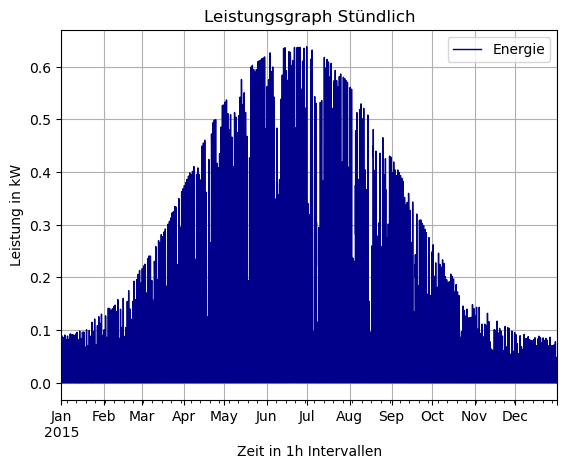

In [7]:
# Extra-Diagramm der 15-Minuten Produktion, hilft bei der Plausibilitätskontrolle
# Input - Array der Standardwerte

# Pandas-Zeitreihe erstellen (15 minuten Takt) 
time_series = pd.date_range(start='2015-01-01 00:00:00', end='2015-12-31 23:59:59', freq='15min')
start_time = pd.Timestamp('2015-01-01 00:00:00')
end_time = pd.Timestamp('2015-12-31 23:59:59')

# Erstellt ein Pandas DataFrame-Objekt df mit 2 Spalten
# Energie: Eine Spalte mit Werten der Energieerzeugung E_gen.
# timesteps: Eine Spalte mit der zugehörigen Zeitreihe time_series.

df = pd.DataFrame({'Energie': G, 'timesteps': time_series})
Gesamt_Energie_with_timesteps = df.set_index('timesteps')
hourly_energy = Gesamt_Energie_with_timesteps.resample('H').sum()
subset = hourly_energy.loc[(hourly_energy.index >= start_time) & (hourly_energy.index <= end_time)]
subset = subset/1000
subset.plot(color ="darkblue", linewidth = 1) 

#Ausgabe, Hinzufügen von Titel + Achsenbeschriftung
plt.title('Leistungsgraph Stündlich')       
plt.xlabel('Zeit in 1h Intervallen')
plt.ylabel('Leistung in kW')
plt.legend()
plt.grid()
plt.show()


Ein Plot der Stündlichen Leistung der Anlage. Ermöglicht eine Plausibilitätsüberprüfung und zeigt gut die saisonalen Unterschiede. 

# 3.2 Leistungsdauerlinie

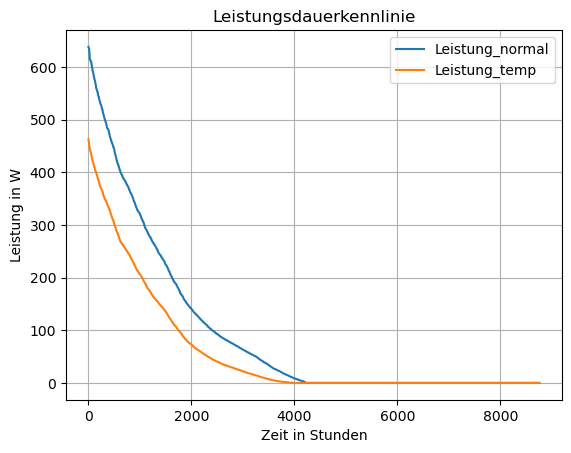

In [8]:
#Leistungsdauerlinie

# reshape the array to hourly data
G_hourly = G.to_numpy().reshape(-1, 4).sum(axis=1)
E_gen_temp_hourly = E_gen_temp.to_numpy().reshape(-1, 4).sum(axis=1)

# sort G_hourly and E_gen_temp_hourly from highest to lowest
G_hourly_sorted_idx = np.argsort(G_hourly)[::-1]
G_hourly_sorted = G_hourly[G_hourly_sorted_idx]
E_gen_temp_hourly_sorted_idx = np.argsort(E_gen_temp_hourly)[::-1]
E_gen_temp_hourly_sorted = E_gen_temp_hourly[E_gen_temp_hourly_sorted_idx]

arr = np.arange(8760)

# Diagramm erstellen
plt.plot(arr, G_hourly_sorted,label='Leistung_normal')
plt.plot(arr, E_gen_temp_hourly_sorted,label='Leistung_temp')

# Diagramm formatieren
plt.title('Leistungsdauerkennlinie')
plt.xlabel('Zeit in Stunden')
plt.ylabel('Leistung in W')
plt.legend()
plt.grid()

# Diagramm anzeigen
plt.show()



Mithilfe der Leistungsdauerkennlinie wird gezeigt, wieviele Stunden im Jahr eine PV Anlage mit einer bestimmten Leistung produziert hat.   
Wie gut zu sehen ist, Pendelt die Betriebszeit um 4000 Stunden.

# 3.3 Monatliche Erträge

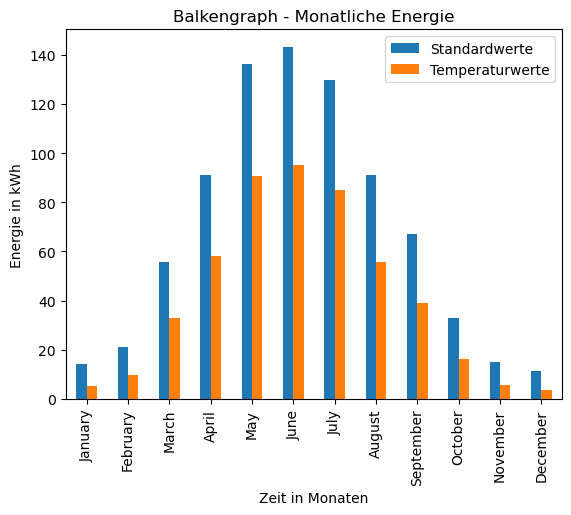

In [9]:
# Monatliche Erträge Barchart

# Erstellt ein Pandas DataFrame-Objekt df mit 2 Spalten
start_time = pd.Timestamp('2015-01-01 00:00:00')
end_time = pd.Timestamp('2015-12-31 23:59:59')

df = pd.DataFrame({'Energie': G/1000, 'timesteps': time_series})
df_temp = pd.DataFrame({'Energie': E_gen_temp/1000, 'timesteps': time_series})
Gesamt_Energie_with_timesteps = df.set_index('timesteps')
Gesamt_Energie_Temp_with_timesteps = df_temp.set_index('timesteps')

# Erstellt Subsets und auswählen der Daten
subset = Gesamt_Energie_with_timesteps.loc[(Gesamt_Energie_with_timesteps.index >= start_time) & (Gesamt_Energie_with_timesteps.index <= end_time)]
subset_temp = Gesamt_Energie_Temp_with_timesteps.loc[(Gesamt_Energie_Temp_with_timesteps.index >= start_time) & (Gesamt_Energie_Temp_with_timesteps.index <= end_time)]

# Resample
hourly_energy = Gesamt_Energie_with_timesteps.resample('H').sum()
hourly_energy_temp = Gesamt_Energie_Temp_with_timesteps.resample('H').sum()
monthly_energy = hourly_energy.resample('M').sum()
monthly_energy_temp = hourly_energy_temp.resample('M').sum()

# Combine
df_combined = pd.DataFrame({'Standardwerte': monthly_energy['Energie'], 'Temperaturwerte': monthly_energy_temp['Energie']})

# Formatieren des index zu ganzen Monaten
df_combined.index = monthly_energy.index.strftime('%B')

# Stacked bar chart
df_combined.plot.bar(stacked = False)
plt.xlabel('Zeit in Monaten')
plt.ylabel('Energie in kWh')
plt.title('Balkengraph - Monatliche Energie')
plt.show()

Ein Balkendiagramm um die Temperaturbedingten Leistungsänderungen der Photovolaikanlage zu visualisieren.  

# 3.4 Maximale und Minimale Tagesproduktion

In [10]:
# 5 Tage mit höchster & geringster Produktivität

# Erstellt ein Pandas DataFrame-Objekt df mit 2 Spalten
start_time = pd.Timestamp('2015-01-01 00:00:00')
end_time = pd.Timestamp('2015-12-31 23:59:59')
df = pd.DataFrame({'Energie': G/1000, 'timesteps': time_series})
Gesamt_Energie_with_timesteps = df.set_index('timesteps')

# Tagesenergie & sort
daily_energy = Gesamt_Energie_with_timesteps.resample('D').sum()
mostleast_df = daily_energy.sort_values('Energie')

min_pv = mostleast_df.head(5) #looks for lowest
max_pv = mostleast_df.tail(5) #looks for highest
min_pv_reversed = min_pv[::-1] #reverses array
max_pv_reversed = max_pv[::-1] #reverses array

# Formating
min_pv_reversed.reset_index(inplace=True) 
min_pv_reversed.index.name = None
max_pv_reversed.reset_index(inplace=True)
max_pv_reversed.index.name = None

# Print
print("Tage mit der minimalen PV-Erzeugung:")
print(min_pv_reversed.to_string(header = False))
print("\n")
print("Tage mit der maximalen PV-Erzeugung")
print(max_pv_reversed.to_string(header = False))

Tage mit der minimalen PV-Erzeugung:
0 2015-12-03  0.267968
1 2015-12-28  0.261531
2 2015-11-27  0.260909
3 2015-12-31  0.249156
4 2015-12-06  0.238306


Tage mit der maximalen PV-Erzeugung
0 2015-06-21  6.277283
1 2015-06-24  6.269047
2 2015-06-23  6.249833
3 2015-07-04  6.165454
4 2015-06-03  6.034379


Juni, Juli klar als stärkste Monate erkennbar.  
November, Dezember an den schwächsten Tagen teils um Faktor 20 schwächer als die Peakwerte in den Sommermonaten.

# 3.5 Direkt, Reflektiv, Diffuse - Leistungsanteile

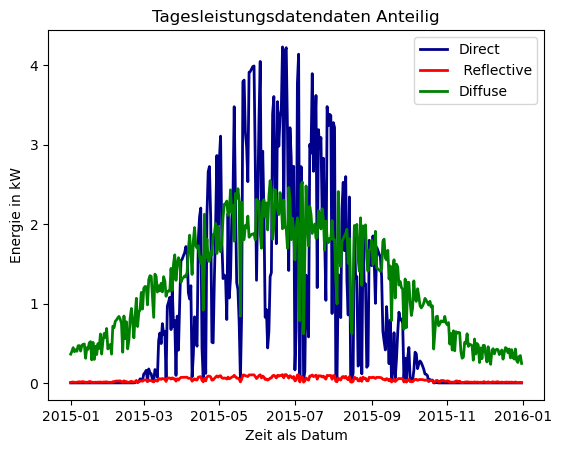

In [11]:
#3-Anteile-Graph

# Erstellt 3 Pandas DataFrames-Objekte df mit 2 Spalten
time_series = pd.date_range(start='2015-01-01 00:00:00', end='2015-12-31 23:59:59', freq='15min')
start_time = pd.Timestamp('2015-01-01 00:00:00')
end_time = pd.Timestamp('2015-12-31 23:59:59')
df_dire = pd.DataFrame({'Energie': E_dire_gen_sum/1000, 'timesteps': time_series})
df_refl = pd.DataFrame({'Energie': E_refl_gen_sum/1000, 'timesteps': time_series})
df_diff = pd.DataFrame({'Energie': E_diff_gen_sum/1000, 'timesteps': time_series})

# Erstellt Subsets und auswählen der Daten
Gesamt_Energie_with_timesteps_sorted_dire = df_dire.set_index('timesteps')
subset_dire = Gesamt_Energie_with_timesteps_sorted_dire.loc[(Gesamt_Energie_with_timesteps_sorted_dire.index >= start_time) & (Gesamt_Energie_with_timesteps_sorted_dire.index <= end_time)]
daily_data_dire = subset_dire.resample('D').sum()

Gesamt_Energie_with_timesteps_sorted_refl = df_refl.set_index('timesteps')
subset_refl = Gesamt_Energie_with_timesteps_sorted_refl.loc[(Gesamt_Energie_with_timesteps_sorted_refl.index >= start_time) & (Gesamt_Energie_with_timesteps_sorted_refl.index <= end_time)]
daily_data_refl = subset_refl.resample('D').sum()

Gesamt_Energie_with_timesteps_sorted_diff = df_diff.set_index('timesteps')
subset_diff = Gesamt_Energie_with_timesteps_sorted_diff.loc[(Gesamt_Energie_with_timesteps_sorted_diff.index >= start_time) & (Gesamt_Energie_with_timesteps_sorted_diff.index <= end_time)]
daily_data_diff = subset_diff.resample('D').sum()


# Ausgabe
plt.plot(daily_data_dire.index, daily_data_dire['Energie'], color='darkblue', linewidth=2, label='Direct')
plt.plot(daily_data_refl.index, daily_data_refl['Energie'], color='red', linewidth=2, label=' Reflective')
plt.plot(daily_data_diff.index, daily_data_diff['Energie'], color='green', linewidth=2, label='Diffuse')

# Adding a title and axis labels
plt.title('Tagesleistungsdatendaten Anteilig')
plt.xlabel('Zeit als Datum')
plt.ylabel('Energie in kW')
plt.legend()
plt.show()


Visualisierung der Strahlungsanteile über ein Jahr.  
Gut zu sehen sind die Peaks von direkter Strahlung in den Sommermonaten, sowie der stärkere Abfall eben dieser in den  
Wintermonaten (im Vergleich zur Diffusen-Strahlung).  
Reflektive Anteile sind nur sehr gering und haben quasi keinen Einfluss.

# 3.6 Boxplots Stromproduktion Juni & Dezember

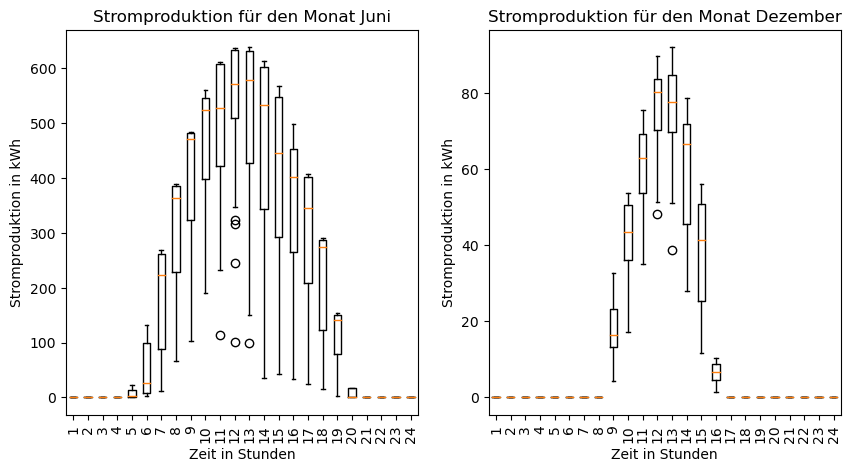

In [12]:
# Boxplot der Stromproduktion von 2 ausgewählten Monaten

# E_gen aufteilen
# 8760 Spalten (Stunden in einem Jahr)
# mit jeweils einer Stunde (4 Zeilen entsprechen 1 h)

temp = np.reshape(G.to_numpy(), (4, 8760), order = 'F')

# Stundenerträge berechnen 
hourly_energy_box = np.sum(temp, axis = 0) 

# Stromproduktion stündlich für beide Monate
# Der Code verwendet die NumPy-reshape-Funktion um ein 1-dimensionales Array mit stündlichen Energie-Daten in ein
# zweidimensionales Array mit 30 Reihen (1 Tag pro Reihe) und 24 Spalten (1 pro stunde pro tag)

juni = np.reshape(hourly_energy_box[151 * 24 : 181 * 24], (30,24)) 
dezember = np.reshape(hourly_energy_box[334 * 24 : 365 * 24], (31,24))

# Initialisierung eines Plots mit 2 Subplots
fig, (juni_plot, dezember_plot) = plt.subplots(1, 2, figsize=(10, 5))  

# Erstellen der Boxplots & Formatieren
juni_plot.boxplot(juni)
juni_plot.set_title('Stromproduktion für den Monat Juni')
juni_plot.set_xlabel('Zeit in Stunden')
juni_plot.set_ylabel('Stromproduktion in kWh')
juni_plot.set_xticklabels(np.arange(1, 25), rotation = 90)

dezember_plot.boxplot(dezember)
dezember_plot.set_title('Stromproduktion für den Monat Dezember')
dezember_plot.set_xlabel('Zeit in Stunden')
dezember_plot.set_ylabel('Stromproduktion in kWh')
dezember_plot.set_xticklabels(np.arange(1, 25), rotation = 90)

plt.show()


Die Höchste Stromproduktion wird im Juni sowie im Dezember um 13 Uhr erziehlt.  
Stromproduktionszeitraum - Juni: 15-16 Stunden pro Tag.  
Stromproduktionszeitraum - Dezember: 8 Stunden pro Tag.

# 4.1 Einfluss des Aufstellwinkels

In [13]:
#Funktion zur Berechnug aller Kombinationen von Aufstellwinkeln (Höhenwinkel und Azimut)
def aufstellwinkel(E_dir_hor, E_diff_hor, E_G_hor, alpha_s, gamma_s, Modulflaeche, data_temp):
    
    gamma_e = 0 #0 - 90 Grad
    alpha_e = 0 #0 - 360 Grad
    
    Ert_arr = np.array([])
    gamma_e_arr = np.array([])
    alpha_e_arr = np.array([])
    
    #schleifen um alle kombinationen abzudecken
    while gamma_e < 91:
        while alpha_e < 361:
            G, E_dire_gen_sum, E_refl_gen_sum, E_diff_gen_sum = jahreserzeugung(E_dir_hor, E_diff_hor, E_G_hor, alpha_s, gamma_s, alpha_e, gamma_e)
            Ert, tmp = jahreserzeugung_temp(G, data_temp)
            Ert_arr = np.append(Ert_arr, Ert)
            gamma_e_arr = np.append(gamma_e_arr, gamma_e)
            alpha_e_arr = np.append(alpha_e_arr, alpha_e)
            alpha_e = alpha_e + 10 #10er schritte
        alpha_e = 0
        
        gamma_e = gamma_e + 2.5 #2.5er schritte
    
    #Rückgabe der arrays für: Erzeugung, Höhenwinkel und Azimut um diese PLoten zu können
    return Ert_arr,gamma_e_arr, alpha_e_arr    


In [14]:
def plot_3D(x,y,z, titel):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(x,y,z,color = "red")
    ax.invert_yaxis() #invertieren der y Achse um eine Gute Ansicht des Plots zu bekommen
    ax.scatter(x[np.argmax(z)], y[np.argmax(z)], z[np.argmax(z)], color = "blue", s = 60) #maximum Wert aller Achsen mit Punkt markieren 

    #Beschriftung der Diagramme
    ax.set_title("Variation der Aufstellwinkel 3D, " + titel, fontsize = 10)
    ax.set_xlabel("Höhenwinkel [Grad]", labelpad = 15)
    ax.set_ylabel("Azimut [Grad]", labelpad = 15)
    ax.set_zlabel("Volllaststunden [h]")
    
    #Plot verkleinern um die z-Achsenbeschrifung lesbar zu machen
    ax.set_box_aspect(aspect=None, zoom=0.8)
    
    plt.show()

In [15]:
def plot_2D(x,y,z,titel):
    
    X = x.reshape(37,37)
    Y = y.reshape(37,37)
    Z = z.reshape(37,37)

    fig, ax = plt.subplots()
    t = ax.contourf(X,Y,Z, levels = 22) #22 level um eine gute Auflösung des Contourplots zu erhalten
    ax.invert_yaxis() 
    ax.scatter(x[np.argmax(z)], y[np.argmax(z)], z[np.argmax(z)], color = "red", marker = "x")
    colorbar = fig.colorbar(t)

    ax.set_title("Variation der Aufstellwinkel Conturplot, " + titel, fontsize = 10)
    ax.set_xlabel("Höhenwinkel [Grad]", labelpad = 15)
    ax.set_ylabel("Azimut [Grad]", labelpad = 15)
    colorbar.set_label("Volllaststunden [h]", labelpad = 15)
    
    plt.show()

# 4.2 3D und 2D Plots der errechneten Daten

Max Erzeugung:  857.65 kWh Bei:  Gamma_e:  32.5 Alpha_e:  10.0


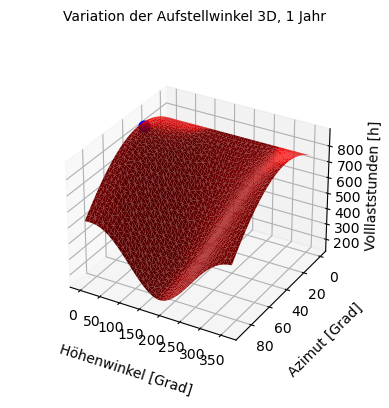

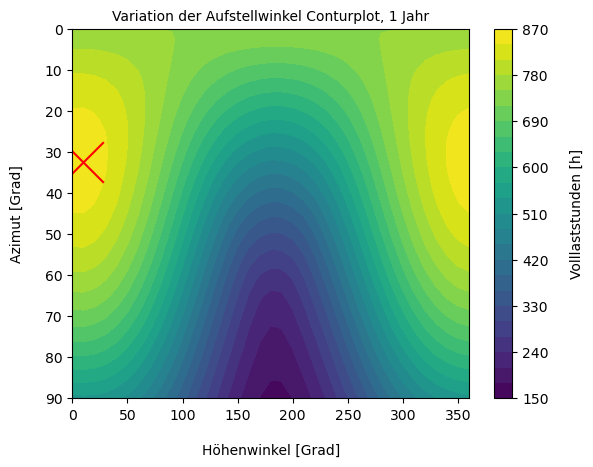

In [16]:
Ert_arr,gamma_e_arr, alpha_e_arr = aufstellwinkel(E_dir_hor, E_diff_hor, E_G_hor, alpha_s, gamma_s, Modulflaeche, data_temp)
print("Max Erzeugung: ", Ert_arr[np.argmax(Ert_arr)], "kWh Bei: ", "Gamma_e: ",gamma_e_arr[np.argmax(Ert_arr)], "Alpha_e: ",alpha_e_arr[np.argmax(Ert_arr)])

plot_3D(alpha_e_arr, gamma_e_arr, Ert_arr, "1 Jahr")
plot_2D(alpha_e_arr, gamma_e_arr, Ert_arr, "1 Jahr")

Den höchsten Ertrag erhält man bei den oben angeführen Parametern. (Wobei: Azimut: Südrichtung = 0°)  
Die Maxima wurden in beiden Diagrammen (blauer Punkt (3D-Plot), rotes X (Contour-Plot)) eingezeichnet.

Max Erzeugung Juni:  121.88 kWh Bei:  Gamma_e:  12.5 Alpha_e:  10.0


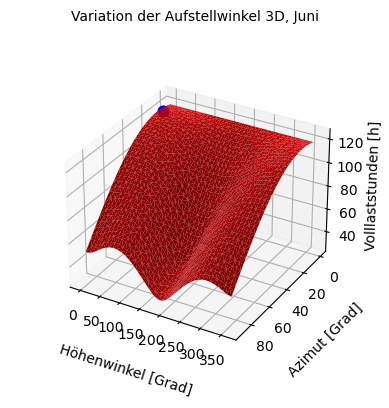

In [17]:
E_dir_hor_juni = data_stra.loc[14496:17375 ,"DirectHoriz"]
E_diff_hor_juni = data_stra.loc[14496:17375 ,"DiffusHoriz"]
E_G_hor_juni = data_stra.loc[14496:17375 ,"GlobalHoriz"]

Ert_arr,gamma_e_arr, alpha_e_arr = aufstellwinkel(E_dir_hor_juni, E_diff_hor_juni, E_G_hor_juni, alpha_s, gamma_s, Modulflaeche, data_temp)
print("Max Erzeugung Juni: ", Ert_arr[np.argmax(Ert_arr)], "kWh Bei: ", "Gamma_e: ",gamma_e_arr[np.argmax(Ert_arr)], "Alpha_e: ",alpha_e_arr[np.argmax(Ert_arr)])
    
plot_3D(alpha_e_arr, gamma_e_arr, Ert_arr, "Juni")

Max Erzeugung December:  20.43 kWh Bei:  Gamma_e:  65.0 Alpha_e:  0.0


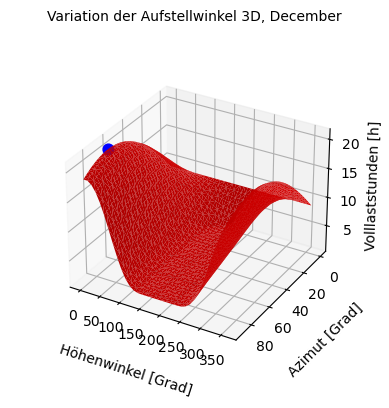

In [18]:
E_dir_hor_dec = data_stra.loc[32063:35039 ,"DirectHoriz"]
E_diff_hor_dec = data_stra.loc[32063:35039 ,"DiffusHoriz"]
E_G_hor_dec = data_stra.loc[32063:35039 ,"GlobalHoriz"]

Ert_arr,gamma_e_arr, alpha_e_arr = aufstellwinkel(E_dir_hor_dec, E_diff_hor_dec, E_G_hor_dec, alpha_s, gamma_s, Modulflaeche, data_temp)
print("Max Erzeugung December: ", Ert_arr[np.argmax(Ert_arr)], "kWh Bei: ", "Gamma_e: ",gamma_e_arr[np.argmax(Ert_arr)], "Alpha_e: ",alpha_e_arr[np.argmax(Ert_arr)])

plot_3D(alpha_e_arr, gamma_e_arr, Ert_arr, "December")


Obenstehende Werte zeigen, dass der Höhenwinkel der Anlage für die Sommermonate um ein vielfaches flacher sein sollte als 
für die Wintermonate, da die Sonnenstarhlen in den Sommermonaten fast senkrecht einfallen.   
Die Maxima wurden wieder in Form von Punken in den Diagrammen eingezeichnet.

# 5.1 Vergleich von zwei Unterschiedlichen Standorten

In [19]:
# Define the latitude and longitude for Hamburg and Madrid
laengengrad_hamburg = 10.00328
breitengrad_hamburg = 53.53987
laengengrad_madrid = -3.71436
breitengrad_madrid = 40.41265

# Read data from CSV files for Hamburg and Madrid
df_ham = pd.read_csv('Hamburg_comma.csv')
df_mad = pd.read_csv('Madrid_comma.csv')

# Calculate the solar panel orientation (azimuth and altitude) relative to the sun for each city
azimut_hamburg, hoehenwinkel_hamburg = sonnenstand(laengengrad_hamburg, breitengrad_hamburg, data_time)
azimut_madrid, hoehenwinkel_madrid = sonnenstand(laengengrad_madrid, breitengrad_madrid, data_time)

# Extract data from the CSV files for each city
E_dire_hor_hamburg = df_ham.loc[0: ,"DirectHoriz"] #spalte aus csv datei mit direct horizontal daten    
E_diff_hor_hamburg = df_ham.loc[0:,"DiffusHoriz"] #spalte aus csv datei mit diffuse horizontal daten    
Eg_hor_hamburg = df_ham.loc[0:, "GlobalHoriz"] #spalte aus csv datei mit global horizontal daten
E_dire_hor_madrid = df_mad.loc[0: ,"DirectHoriz"] #spalte aus csv datei mit direct horizontal daten    
E_diff_hor_madrid = df_mad.loc[0:,"DiffusHoriz"] #spalte aus csv datei mit diffuse horizontal daten    
Eg_hor_madrid = df_mad.loc[0:, "GlobalHoriz"] #spalte aus csv datei mit global horizontal daten

# Calculate the yearly solar power generation and number of full-load hours for each city
E_gen_hamburg, E_dire_gen_sum_hamburg, E_refl_gen_sum_hamburg, E_diff_gen_sum_hamburg = jahreserzeugung(E_dire_hor_hamburg, Eg_hor_hamburg, E_diff_hor_hamburg, azimut_hamburg, hoehenwinkel_hamburg, pv_azimut, pv_hoehenwinkel)
Einstrahlungsleistung_Summe_hamburg = np.sum(E_gen_hamburg)
E_gen_madrid, E_dire_gen_sum_madrid, E_refl_gen_sum_madrid, E_diff_gen_sum_madrid = jahreserzeugung(E_dire_hor_madrid, Eg_hor_madrid, E_diff_hor_madrid, azimut_madrid, hoehenwinkel_madrid, pv_azimut, pv_hoehenwinkel)
Einstrahlungsleistung_Summe_madrid = np.sum(E_gen_madrid)

# Calculate the annual energy yield for Hamburg and Madrid, in kWh
Jahresertrag_hamburg = np.round((Einstrahlungsleistung_Summe_hamburg * Modulflaeche * Modulwirkungsgrad * SonstigeVerluste) / 1000,2)
Jahresertrag_madrid = np.round((Einstrahlungsleistung_Summe_madrid * Modulflaeche * Modulwirkungsgrad * SonstigeVerluste) / 1000,2)
print("Jaresertrag 2005 - Hamburg: ",Jahresertrag_hamburg,"kWh")
print("Jaresertrag 2005 - Madrid: ",Jahresertrag_madrid,"kWh")
print("Jaresertrag 2005 - Wien: ",Jahresertrag,"kWh")

# Calculate the full load hours for Hamburg and Madrid, in hours
Volllaststunden_hamburg = Jahresertrag_hamburg / Installpv
Volllaststunden_madrid = Jahresertrag_madrid / Installpv
print("Volllaststunden für diese Anlage im Jahr 2005 - Hamburg: ",Volllaststunden_hamburg,"h")
print("Volllaststunden für diese Anlage im Jahr 2005 - Madrid: ",Volllaststunden_madrid,"h")
print("Volllaststunden für diese Anlage im Jahr 2005 - Wien: ",Volllaststunden,"h")

Jaresertrag 2005 - Hamburg:  941.89 kWh
Jaresertrag 2005 - Madrid:  1912.78 kWh
Jaresertrag 2005 - Wien:  647.17 kWh
Volllaststunden für diese Anlage im Jahr 2005 - Hamburg:  941.89 h
Volllaststunden für diese Anlage im Jahr 2005 - Madrid:  1912.78 h
Volllaststunden für diese Anlage im Jahr 2005 - Wien:  647.17 h


# 5.2 Vergleich auf Basis der durchschnittlichen Tagesproduktion

In [20]:
# Resize the arrays E_gen_hamburg and E_gen_madrid to shape (365, 96) and calculate the daily energy generation for each location
E_gen_hamburg_reshaped = np.resize((np.array(E_gen_hamburg) * Modulflaeche * Modulwirkungsgrad * SonstigeVerluste), (365, 96))
E_gen_madrid_reshaped = np.reshape((np.array(E_gen_madrid) * Modulflaeche * Modulwirkungsgrad * SonstigeVerluste), (365, 96))

# Calculate the daily mean energy generation for Hamburg and Madrid by taking the mean along the second axis (axis=1)
daily_mean_energy_hamburg = np.mean(E_gen_hamburg_reshaped, axis=1)
daily_mean_energy_madrid = np.mean(E_gen_madrid_reshaped, axis=1)

# Calculate the overall mean of the daily mean energy generation for Hamburg and Madrid
mean_daily_hamburg = np.round(np.mean(daily_mean_energy_hamburg),2)
mean_daily_madrid = np.round(np.mean(daily_mean_energy_madrid), 2)

# Print the calculated average daily energy generation for Hamburg and Madrid
print(f"durchschnittliche Tagesproduktion in Hamburg: {mean_daily_hamburg} Wh")
print(f"durchschnittliche Tagesproduktion in Madrid: {mean_daily_madrid} Wh")

durchschnittliche Tagesproduktion in Hamburg: 26.88 Wh
durchschnittliche Tagesproduktion in Madrid: 54.59 Wh


# 5.3 3D Plots der Variation der Aufstellwinkel für beide Standorte

Max Erzeugung Hamburg:  779.51 kWh Bei:  Gamma_e:  40.0 Alpha_e:  30.0


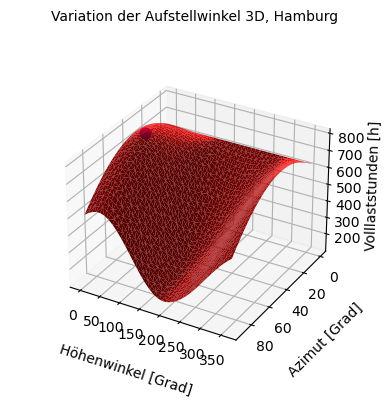

Max Erzeugung Madrid:  1593.02 kWh Bei:  Gamma_e:  40.0 Alpha_e:  30.0


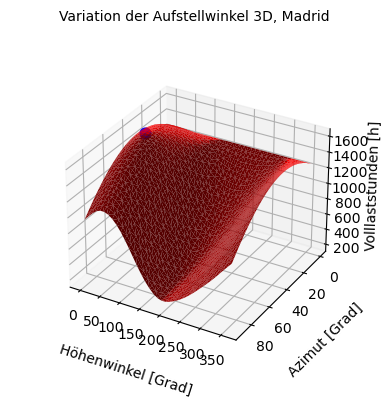

In [21]:
#Calculate and plot energy generation based on tilt for Hamburg and Madrid
Ert_arr,gamma_e_arr, alpha_e_arr = aufstellwinkel(E_dire_hor_hamburg, E_diff_hor_hamburg, Eg_hor_hamburg, azimut_hamburg, hoehenwinkel_hamburg, Modulflaeche, data_temp)
print("Max Erzeugung Hamburg: ", Ert_arr[np.argmax(Ert_arr)], "kWh Bei: ", "Gamma_e: ",gamma_e_arr[np.argmax(Ert_arr)], "Alpha_e: ",alpha_e_arr[np.argmax(Ert_arr)])
    
plot_3D(alpha_e_arr, gamma_e_arr, Ert_arr, "Hamburg")


Ert_arr,gamma_e_arr, alpha_e_arr = aufstellwinkel(E_dire_hor_madrid, E_diff_hor_madrid, Eg_hor_madrid, azimut_madrid, hoehenwinkel_madrid, Modulflaeche, data_temp)
print("Max Erzeugung Madrid: ", Ert_arr[np.argmax(Ert_arr)], "kWh Bei: ", "Gamma_e: ",gamma_e_arr[np.argmax(Ert_arr)], "Alpha_e: ",alpha_e_arr[np.argmax(Ert_arr)])
 
plot_3D(alpha_e_arr, gamma_e_arr, Ert_arr, "Madrid")

Die Energieerzeugung von PV-Systemen hängt von Standort, Tageszeit, Jahreszeit, Wetterbedingungen und der Ausrichtung der Paneelen ab. 
Regionen in der Nähe des Äquators erzeugen aufgrund höherer Sonnenlichtintensität mehr Energie.   
Die Mittagszeit liefert die meiste Energie, während eine schwächere Intensität am Morgen und Abend zu einer geringeren Erzeugung führt. 
Im Sommer mit längeren und intensiveren Sonnenlichtzeiten gibt es höhere Erträge als im Winter. 
Eine optimale Ausrichtung und Neigung der Paneele kann die Energieerzeugung maximieren.